### Konstrukcija dataset-a


In [459]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
# import nltkc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, chi2
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt
from rapidfuzz import distance
from wordcloud import WordCloud, STOPWORDS
import contractions
%matplotlib inline

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\legion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\legion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\legion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\legion\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Ucitavanje dataset-ova i njihova konkatenacija


In [460]:
df1 = pd.read_csv("./raw_data/nazario/Nazario.csv")
df2 = pd.read_csv("./raw_data/spam-assasin/SpamAssasin_preprocessed.csv")
# since both datasets contain both ham and phishing emails, we perform a simple concatenation.
df = pd.concat([df1, df2], ignore_index=True)

### Pretprocesianje


Inicijalni podaci


In [461]:
df.head()

,sender,receiver,date,subject,body,label,urls
0,"""Hu, Sylvia"" <Sylvia.Hu@ENRON.com>","""Acevedo, Felecia"" <Felecia.Acevedo@ENRON.com>...","Fri, 29 Jun 2001 08:36:09 -0500","FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n\n\n ...,0,"['http://web.bna.com', 'http://pubs.bna.com/ip..."
1,"""Webb, Jay"" <Jay.Webb@ENRON.com>","""Lambie, Chris"" <Chris.Lambie@ENRON.com>","Fri, 29 Jun 2001 09:37:04 -0500",NGX failover plan.,"\nHi Chris, \n\nTonight we are rolling out a ...",0,[]
2,"""Symms, Mark"" <Mark.Symms@ENRON.com>","""Thomas, Paul D."" <Paul.D.Thomas@ENRON.com>","Fri, 29 Jun 2001 08:39:30 -0500",RE: Intranet Site,Rika r these new?\n\n -----Original Message---...,0,['http://eastpower.dev.corp.enron.com/summary/...
3,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>","""Grass, John"" <John.Grass@ENRON.com>, ""Nemec, ...","Fri, 29 Jun 2001 10:35:17 -0500",FW: ENA Upstream Company information,"John/Gerald,\n\nWe are currently trading under...",0,[]
4,"""Williams, Jason R (Credit)"" <Jason.R.Williams...","""Nemec, Gerald"" <Gerald.Nemec@ENRON.com>, ""Dic...","Fri, 29 Jun 2001 10:40:02 -0500",New Master Physical,Gerald and Stacy -\n\nAttached is a worksheet ...,0,[]


In [462]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5847 entries, 0 to 5846
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    5845 non-null   object
 1   receiver  5637 non-null   object
 2   date      5844 non-null   object
 3   subject   5784 non-null   object
 4   body      5846 non-null   object
 5   label     5847 non-null   int64 
 6   urls      5847 non-null   object
dtypes: int64(1), object(6)
memory usage: 319.9+ KB


In [463]:
df.shape

(5847, 7)

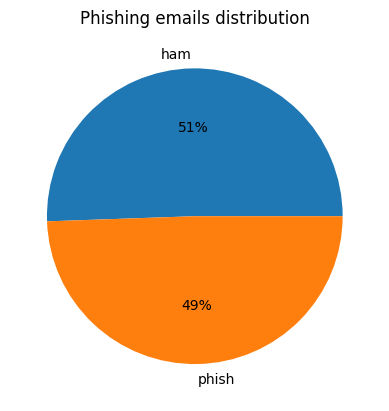

In [464]:
sms = pd.Series(
    df["label"],
).value_counts(sort=True)
sms.plot(kind="pie", labels=["ham", "phish"], autopct="%1.0f%%")

plt.title("Phishing emails distribution")
plt.ylabel("")
plt.show()

Vidimo da je dataset balansiran, te nije potrebna njegovo naknadno balansiranje


In [465]:
# conversion of the body column to a string due to the presence of other data types (float)
df["body"] = df["body"].apply(lambda b: str(b))
# calc length of body column

df["length"] = df["body"].apply(len)


df.head()

,sender,receiver,date,subject,body,label,urls,length
0,"""Hu, Sylvia"" <Sylvia.Hu@ENRON.com>","""Acevedo, Felecia"" <Felecia.Acevedo@ENRON.com>...","Fri, 29 Jun 2001 08:36:09 -0500","FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n\n\n ...,0,"['http://web.bna.com', 'http://pubs.bna.com/ip...",16280
1,"""Webb, Jay"" <Jay.Webb@ENRON.com>","""Lambie, Chris"" <Chris.Lambie@ENRON.com>","Fri, 29 Jun 2001 09:37:04 -0500",NGX failover plan.,"\nHi Chris, \n\nTonight we are rolling out a ...",0,[],539
2,"""Symms, Mark"" <Mark.Symms@ENRON.com>","""Thomas, Paul D."" <Paul.D.Thomas@ENRON.com>","Fri, 29 Jun 2001 08:39:30 -0500",RE: Intranet Site,Rika r these new?\n\n -----Original Message---...,0,['http://eastpower.dev.corp.enron.com/summary/...,577
3,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>","""Grass, John"" <John.Grass@ENRON.com>, ""Nemec, ...","Fri, 29 Jun 2001 10:35:17 -0500",FW: ENA Upstream Company information,"John/Gerald,\n\nWe are currently trading under...",0,[],1608
4,"""Williams, Jason R (Credit)"" <Jason.R.Williams...","""Nemec, Gerald"" <Gerald.Nemec@ENRON.com>, ""Dic...","Fri, 29 Jun 2001 10:40:02 -0500",New Master Physical,Gerald and Stacy -\n\nAttached is a worksheet ...,0,[],290


Razdvajamo phishing i ham mail-ove


In [466]:
phishing_df = df[df["label"] == 1]
ham_df = df[df["label"] == 0]

In [467]:
np.histogram(phishing_df["length"])

(array([2954,    0,    1,    0,    0,    0,    0,    0,    0,    1],
       dtype=int64),
 array([1.0000000e+00, 4.5996530e+05, 9.1992960e+05, 1.3798939e+06,
        1.8398582e+06, 2.2998225e+06, 2.7597868e+06, 3.2197511e+06,
        3.6797154e+06, 4.1396797e+06, 4.5996440e+06]))

Vidimo da je vecina vrijednosti u prvom bin-u histograma, i da postoje outlieri. Filtriramo ih, jer iako je u pitanju phishing email, postoji samo par primjeraka, te nije od velikog znacaja.


In [468]:
phishing_df["length"].describe()

count    2.956000e+03
mean     3.971867e+03
std      8.682174e+04
min      1.000000e+00
25%      5.210000e+02
50%      9.655000e+02
75%      1.858000e+03
max      4.599644e+06
Name: length, dtype: float64

In [469]:
ham_df["length"].describe()

count      2891.000000
mean       2259.582152
std        7310.823104
min          20.000000
25%         531.500000
50%        1011.000000
75%        1933.500000
max      299201.000000
Name: length, dtype: float64

<Axes: xlabel='length'>

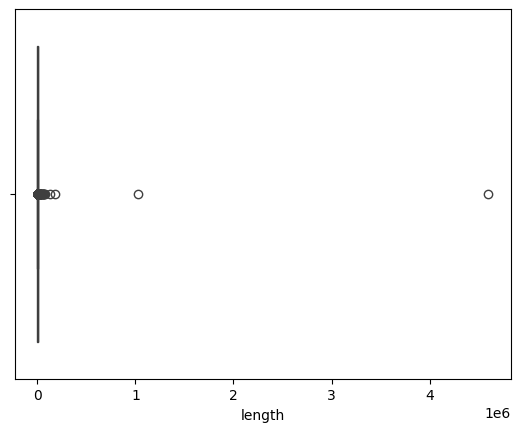

In [470]:
sns.boxplot(x=phishing_df["length"])

In [471]:
phishing_df.sort_values("length", ascending=False)["length"].head(20)

1500    4599644
2033    1025016
5160     184164
5237     125158
5252      72949
4709      71524
4954      67239
4785      60218
4793      59764
4875      52012
5013      49976
5399      43811
5669      41330
5307      37559
4941      27082
5653      26665
5267      25505
5070      24309
5833      24149
4524      23852
Name: length, dtype: int64

<Axes: xlabel='length'>

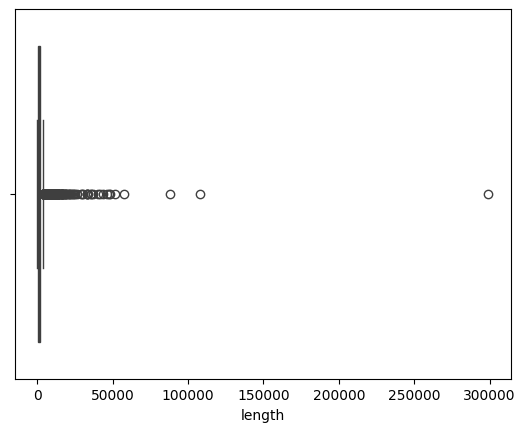

In [472]:
sns.boxplot(x=ham_df["length"])

In [473]:
ham_df.sort_values("length", ascending=False)["length"].head(20)

3543    299201
3554    108015
3207     87972
1179     57732
975      51321
1365     47972
972      47712
965      46219
1188     43434
1020     41412
3560     40201
984      36631
4274     35343
1464     35343
3998     33733
1001     33228
1112     32996
1182     32888
689      30515
1197     29448
Name: length, dtype: int64

Iako se, domenski gledano, postojanje outlier-a u phishing email-ovima ne ogleda u samoj duzini poruke, uklonicemo mejlove cija duzina prelazi 30000 karaktera, jer cemo na taj nacin olaksati dalji rad, a necemo izgubiti znacajne informacije.


In [474]:
phishing_df = phishing_df[phishing_df["length"] < 30_000]
ham_df = ham_df[ham_df["length"] < 30_000]

<Axes: xlabel='length'>

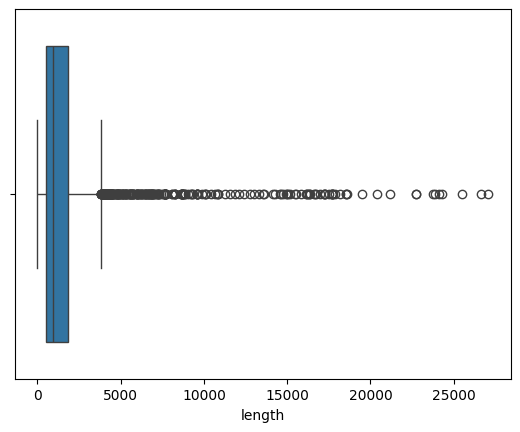

In [475]:
sns.boxplot(x=phishing_df["length"])

<Axes: xlabel='length'>

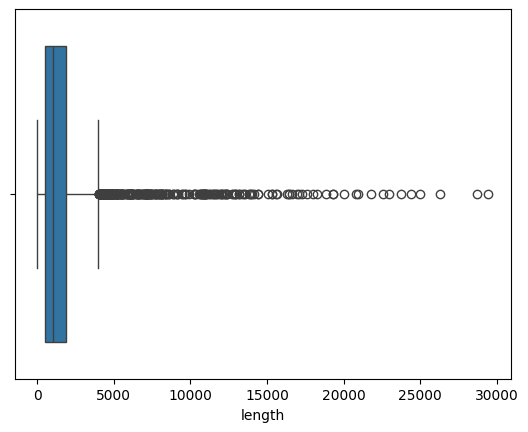

In [476]:
sns.boxplot(x=ham_df["length"])

Pogledacemo odnos duzina phishing i ham email-ova


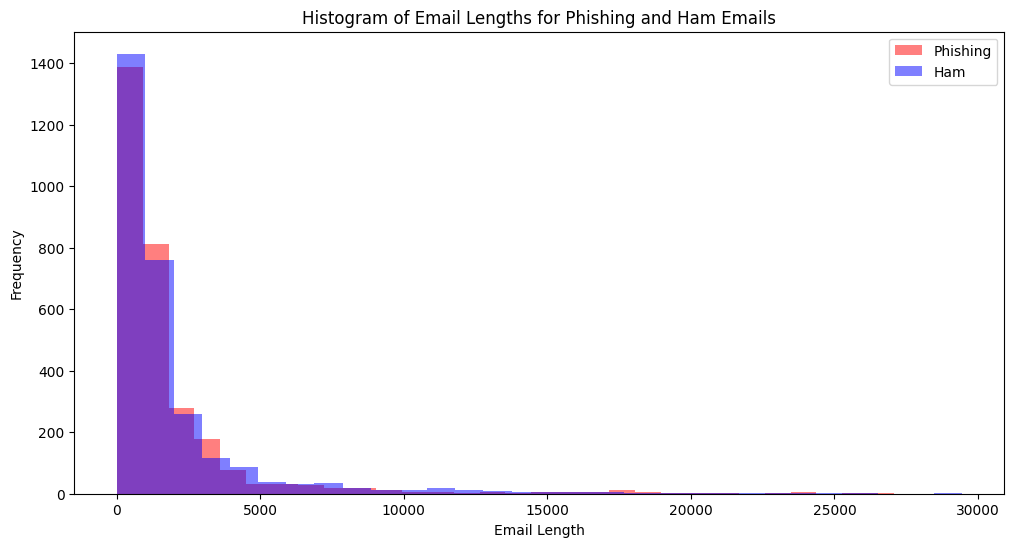

In [477]:
np.histogram(phishing_df["length"])

plt.figure(figsize=(12, 6))

plt.hist(phishing_df["length"], bins=30, alpha=0.5, color="red", label="Phishing")

plt.hist(ham_df["length"], bins=30, alpha=0.5, color="blue", label="Ham")

plt.title("Histogram of Email Lengths for Phishing and Ham Emails")
plt.xlabel("Email Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

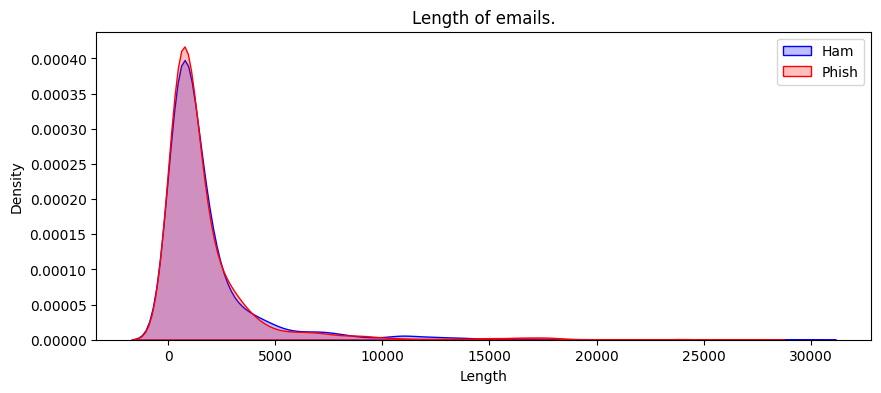

In [478]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(ham_df["length"], fill=True, label="Ham", color="b")
sns.kdeplot(phishing_df["length"], fill=True, label="Phish", color="r")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of emails.",
)
ax.legend(loc="upper right")
plt.show()

In [479]:
df.isna().sum()

sender        2
receiver    210
date          3
subject      63
body          0
label         0
urls          0
length        0
dtype: int64

Receiver kolona nije od interesa, dok subject kolonu popunjavamo praznim stringom na mjestima gdje nedostaju vrijednosti


In [480]:
# drop receiver column
df.drop(["receiver", "date"], axis=1, inplace=True)


df["subject"].fillna("", inplace=True)

df.head(10)

,sender,subject,body,label,urls,length
0,"""Hu, Sylvia"" <Sylvia.Hu@ENRON.com>","FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr\nPW: bnaweb22\n\n\n ...,0,"['http://web.bna.com', 'http://pubs.bna.com/ip...",16280
1,"""Webb, Jay"" <Jay.Webb@ENRON.com>",NGX failover plan.,"\nHi Chris, \n\nTonight we are rolling out a ...",0,[],539
2,"""Symms, Mark"" <Mark.Symms@ENRON.com>",RE: Intranet Site,Rika r these new?\n\n -----Original Message---...,0,['http://eastpower.dev.corp.enron.com/summary/...,577
3,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>",FW: ENA Upstream Company information,"John/Gerald,\n\nWe are currently trading under...",0,[],1608
4,"""Williams, Jason R (Credit)"" <Jason.R.Williams...",New Master Physical,Gerald and Stacy -\n\nAttached is a worksheet ...,0,[],290
5,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>",FW: ENA Upstream Company/Mirant GISB,FYI. Below is a copy of my communication with ...,0,[],1395
6,"""Brennan, Lorna"" <Lorna.Brennan@ENRON.com>",PG&E GT-NW Receives Open Season Requests Total...,PG&E GT-NW Plans Lateral Across Washington Sta...,0,[],2156
7,"""Shah, Kal"" <Kal.Shah@ENRON.com>",Internet Advertising agreement,Mark -- I am working with the East power desk ...,0,[],522
8,"""Shah, Kal"" <Kal.Shah@ENRON.com>",FW: Internet Advertising agreement,oops. here it is.\n\nkal\n \n\n\n\n -----Orig...,0,[],702
9,"""Gimble, Mathew"" <Mathew.Gimble@ENRON.com>",FMPA Oil Invoice,"Mark and Charlie,\n\nFMPA is ready to bill us ...",0,[],502


In [481]:
df.nunique()

sender     3890
subject    4841
body       5764
label         2
urls       1645
length     2807
dtype: int64

Posmatranjem subject-a i body-ja poruka uviđamo da se određene poruke razlikuju samo u whitespace karakterima, te ih uklanjamo u cilju pronalaska duplikata


In [482]:
df["subject"] = df["subject"].apply(lambda x: re.sub(r"\s+", " ", x)).str.lower()
df["body"] = df["body"].apply(lambda x: re.sub(r"\s+", " ", x)).str.lower()

duplicates = df.loc[
    df.duplicated(subset=["sender", "subject", "body"], keep="first").values
]
duplicates.head()

,sender,subject,body,label,urls,length
428,Vijay Gill <vijay@gl.umbc.edu>,gnots,seeing the overwhelming response to my nofile...,0,[],760
1649,"""=?utf-8?Q?noreplay=40intl=2Epaypal=2Ecom?="" <...",=?utf-8?q?we=20noticed=20some=20unusual=20log=...,"response required. dear jose@monkey.org, we em...",1,1,1499
1946,Barclays Bank Plc <barclays_11@outlook.com>,re; barclay bank reference attached.,barclay bank plc london have approve your pay...,1,0,194
2021,<feedback@service.alibaba.com>,[alibaba inquiry notification] 38 unread notif...,"dear alibaba member. ,you have 38 companies in...",1,1,231
2371,shipment@fedex.com,=?utf-8?b?4pyiifryywnriflvdxigu2hpcg1lbnqglsbg...,enter your tracking number to track and pay de...,1,1,579


Email-ove koji su duplikati samo po 'body' koloni ne uklanjamo, jer nam i informacije o posiljaocu i subject-u mogu biti od interesa


In [483]:
df.drop_duplicates(subset=["sender", "subject", "body"], inplace=True, keep="first")
print(df.shape)
base_df = df.copy(deep=True)

(5756, 6)


Zamjenicemo url-ove, html tagove, email adrese i brojave za odgovarajucim tagovima. Inicijalno je vrseno njihovo potpuno uklanjanje ali ovakve informacije mogu biti od znacaja za samu detekciju te i necemo potpuno izgubiti


In [484]:
df["body"] = df["body"].apply(
    lambda x: re.sub("<.*?>", "htmltag", x)
)  # remove html tags

# contractions is the package in python used to expand the contractions in english language to their original form. Example: I'll to "I will"

df["body"] = df["body"].apply(lambda x: contractions.fix(x))  # contractions


df["body"] = df["body"].apply(
    lambda x: re.sub(r"http[s]?://\S+", "urltag", x)
)  # remove urls


df["body"] = df["body"].apply(

    lambda x: re.sub(
        r"\b[A-Za-z0-9._%+-]+@([A-Za-z0-9.-]+\.[A-Z|a-z]{2,})\b", "emailaddresstag", x
    )

)  # remove emails


df["body"] = df["body"].apply(
    lambda x: re.sub(r"\b\d+\b", "digittag", x)
)  # remove digits
df.head()

,sender,subject,body,label,urls,length
0,"""Hu, Sylvia"" <Sylvia.Hu@ENRON.com>","fw: june 29 -- bna, inc. daily labor report",user id: enrondlr pw: bnaweb22 -----original m...,0,"['http://web.bna.com', 'http://pubs.bna.com/ip...",16280
1,"""Webb, Jay"" <Jay.Webb@ENRON.com>",ngx failover plan.,"hi chris, tonight we are rolling out a new re...",0,[],539
2,"""Symms, Mark"" <Mark.Symms@ENRON.com>",re: intranet site,rika r these new? -----original message----- f...,0,['http://eastpower.dev.corp.enron.com/summary/...,577
3,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>",fw: ena upstream company information,"john/gerald, we are currently trading under gt...",0,[],1608
4,"""Williams, Jason R (Credit)"" <Jason.R.Williams...",new master physical,gerald and stacy - attached is a worksheet for...,0,[],290


Uklanjanje specijalnih karaktera, \s karaktera, lowercase


In [485]:
df["subject"] = (
    df["subject"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s'-]", "", x)).str.lower()
)
df["body"] = df["body"].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s'-]", "", x)).str.lower()
df.head()

,sender,subject,body,label,urls,length
0,"""Hu, Sylvia"" <Sylvia.Hu@ENRON.com>",fw june 29 -- bna inc daily labor report,user id enrondlr pw bnaweb22 -----original mes...,0,"['http://web.bna.com', 'http://pubs.bna.com/ip...",16280
1,"""Webb, Jay"" <Jay.Webb@ENRON.com>",ngx failover plan,hi chris tonight we are rolling out a new rep...,0,[],539
2,"""Symms, Mark"" <Mark.Symms@ENRON.com>",re intranet site,rika r these new -----original message----- fr...,0,['http://eastpower.dev.corp.enron.com/summary/...,577
3,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>",fw ena upstream company information,johngerald we are currently trading under gtc ...,0,[],1608
4,"""Williams, Jason R (Credit)"" <Jason.R.Williams...",new master physical,gerald and stacy - attached is a worksheet for...,0,[],290


WordCloud analiza


Body WordCloud


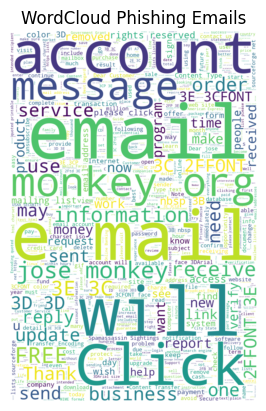

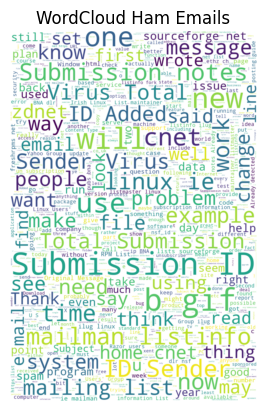

In [486]:
phishing_text = " ".join(body for body in phishing_df.body)
wc_phishing = WordCloud(
    background_color="white",
    stopwords=STOPWORDS,
    max_words=1000,
    width=1000,
    height=1500,
)
wc_phishing = wc_phishing.generate(phishing_text)

plt.imshow(wc_phishing, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Phishing Emails")
plt.show()

ham_text = " ".join(body for body in ham_df.body)
wc_ham = WordCloud(
    background_color="white",
    stopwords=STOPWORDS,
    max_words=1000,
    width=1000,
    height=1500,
)
wc_ham = wc_ham.generate(ham_text)

plt.imshow(wc_ham, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Ham Emails")
plt.show()

Subject WordCloud


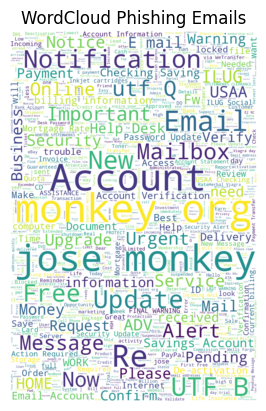

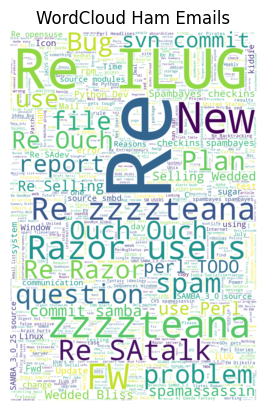

In [487]:
phishing_text = " ".join(subj for subj in phishing_df.subject.astype(str))
wc_phishing = WordCloud(
    background_color="white",
    stopwords=STOPWORDS,
    max_words=1000,
    width=1000,
    height=1500,
)
wc_phishing = wc_phishing.generate(phishing_text)

plt.imshow(wc_phishing, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Phishing Emails")
plt.show()

ham_text = " ".join(subj for subj in ham_df.subject.astype(str))
wc_ham = WordCloud(
    background_color="white",
    stopwords=STOPWORDS,
    max_words=1000,
    width=1000,
    height=1500,
)
wc_ham = wc_ham.generate(ham_text)

plt.imshow(wc_ham, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Ham Emails")
plt.show()

#### Tokenizacija i uklanjanje stop rijeci


In [488]:
stop_words = set(stopwords.words("english"))
df_tokens = df.copy(deep=True)

df_tokens["subject"] = df_tokens["subject"].apply(word_tokenize)
df_tokens["subject"] = df_tokens["subject"].apply(
    lambda tokens: [token for token in tokens if token.lower() not in stop_words]
)
df_tokens["body"] = df_tokens["body"].apply(word_tokenize)
df_tokens["body"] = df_tokens["body"].apply(
    lambda tokens: [token for token in tokens if token.lower() not in stop_words]
)

Lematizacija i POS tagovanje


In [489]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None


def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    pos_tagged_list = nltk.pos_tag(tokens)
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag))
        for token, tag in pos_tagged_list
        if get_wordnet_pos(tag) is not None
    ]
    return lemmatized_tokens


df_tokens["subject"] = df_tokens["subject"].apply(lemmatize)
df_tokens["body"] = df_tokens["body"].apply(lemmatize)

In [490]:
df_tokens.head()

,sender,subject,body,label,urls,length
0,"""Hu, Sylvia"" <Sylvia.Hu@ENRON.com>","[fw, june, bna, inc, daily, labor, report]","[user, id, enrondlr, pw, bnaweb22, -original, ...",0,"['http://web.bna.com', 'http://pubs.bna.com/ip...",16280
1,"""Webb, Jay"" <Jay.Webb@ENRON.com>","[ngx, failover, plan]","[hi, chris, tonight, roll, new, report, curren...",0,[],539
2,"""Symms, Mark"" <Mark.Symms@ENRON.com>","[intranet, site]","[r, new, -original, message, thomas, paul, sen...",0,['http://eastpower.dev.corp.enron.com/summary/...,577
3,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>","[fw, ena, upstream, company, information]","[johngerald, currently, trade, gtc, spot, cont...",0,[],1608
4,"""Williams, Jason R (Credit)"" <Jason.R.Williams...","[new, master, physical]","[gerald, stacy, attach, new, master, physical,...",0,[],290


## Ekstrakcija featurea


### TF-IDF


Body kolona


In [491]:
tfidf_model = TfidfVectorizer(max_features=1000)
tfidf_body_vector = tfidf_model.fit_transform(
    df_tokens["body"].apply(lambda x: " ".join(x))
)
tfidf_body_df = pd.DataFrame(
    tfidf_body_vector.toarray(), columns=tfidf_model.get_feature_names_out()
)
tfidf_body_df

,ability,able,absa,absolutely,accept,access,accord,account,act,action,...,world,worth,write,wrong,yahoo,year,yes,yet,york,yous
0,0.050268,0.0,0.0,0.0,0.0,0.022725,0.01696,0.009054,0.059009,0.0,...,0.035557,0.0,0.000000,0.0,0.0,0.096000,0.000000,0.0,0.116899,0.015319
1,0.000000,0.0,0.0,0.0,0.0,0.250855,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.346096,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5751,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.056017,0.000000,0.0,0.000000,0.000000
5752,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.126181,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
5753,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.038600,0.054276,0.0,0.000000,0.000000
5754,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000


Subject kolona


In [492]:
tfidf_model = TfidfVectorizer(max_features=500)
tfidf_subj_vector = tfidf_model.fit_transform(
    df_tokens["subject"].apply(lambda x: " ".join(x))
)
tfidf_subj_df = pd.DataFrame(
    tfidf_subj_vector.toarray(), columns=tfidf_model.get_feature_names_out()
)
tfidf_subj_df

,01,08,09,10,2002,access,account,action,activation,activity,...,window,wm,woman,word,work,world,wrong,ximian,year,zzzzteana
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
5752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.54062,0.0,0.0,0.0,0.0,0.0
5753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
5754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


Spajamo TF_IDF body i subject metrike


In [493]:
from scipy.sparse import hstack

tfidf_vector = hstack([tfidf_body_vector, tfidf_subj_vector])

df_column_names = tfidf_body_df.columns.tolist() + tfidf_subj_df.columns.tolist()

tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=df_column_names)
tfidf_df

,ability,able,absa,absolutely,accept,access,accord,account,act,action,...,window,wm,woman,word,work,world,wrong,ximian,year,zzzzteana
0,0.050268,0.0,0.0,0.0,0.0,0.022725,0.01696,0.009054,0.059009,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.250855,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5751,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
5752,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.54062,0.0,0.0,0.0,0.0,0.0
5753,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
5754,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


#### Selekcija feature-a putem chi-square metode


In [494]:
def chi2_feature_selection(features, class_col, percentile=50):
    output = dict()

    chi2_selector = SelectPercentile(chi2, percentile=percentile)

    chi2_features_train = chi2_selector.fit_transform(features, class_col)
    selected_features_train = pd.DataFrame(
        chi2_features_train, columns=chi2_selector.get_feature_names_out()
    )

    output["selector"] = chi2_selector
    output["features"] = selected_features_train

    return output

In [495]:
selected_tfidf = chi2_feature_selection(tfidf_df, df["label"])
selected_tfidf_features = selected_tfidf["features"]

Dodajemo label kolonu na kraj


In [496]:
df_reset = df.reset_index(drop=True)
selected_tfidf_features["label"] = df_reset["label"]
selected_tfidf_features.head()

,absa,access,account,action,activity,actually,address,administrator,age,alias,...,well,wetransfer,window,word,world,wrong,ximian,year,zzzzteana,label
0,0.0,0.022725,0.009054,0.0,0.014582,0.014001,0.000000,0.014705,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.250855,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.064209,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.228481,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Word2Vec


In [497]:
import multiprocessing


def filter_vocab_words(wordlist, vocabulary):
    return [word for word in wordlist if word in vocabulary]


def get_mean_vector(wordlist, word2vec_model):
    if len(wordlist) >= 1:
        return np.mean(word2vec_model.wv[wordlist], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)


cores = multiprocessing.cpu_count()

Body kolona


In [498]:
word2Vec_body_model = Word2Vec(
    df_tokens["body"], min_count=5, max_final_vocab=5000, workers=cores - 1
)
filtered_body_col = df_tokens["body"].apply(
    filter_vocab_words, vocabulary=word2Vec_body_model.wv.key_to_index.keys()
)

body_col_with_means = filtered_body_col.apply(
    get_mean_vector, word2vec_model=word2Vec_body_model
)

Subject kolona


In [499]:
word2Vec_subj_model = Word2Vec(
    df_tokens["subject"], min_count=5, max_final_vocab=250, workers=cores - 1
)
filtered_subj_col = df_tokens["subject"].apply(
    filter_vocab_words, vocabulary=word2Vec_subj_model.wv.key_to_index.keys()
)
subj_col_with_means = filtered_subj_col.apply(
    get_mean_vector, word2vec_model=word2Vec_subj_model
)

In [500]:
body_col_with_means_df = pd.DataFrame(body_col_with_means.tolist())
subj_col_with_means_df = pd.DataFrame(subj_col_with_means.tolist())

Spajanje subject i body


In [501]:
selected_word2vec_features = pd.concat(
    [
        body_col_with_means_df,
        subj_col_with_means_df,
    ],
    axis=1,
)

Dodavanje label kolone na kraj


In [502]:
df_reset = df.reset_index(drop=True)
selected_word2vec_features["label"] = df_reset["label"]
selected_word2vec_features.shape

(5756, 201)

### Cuvanje rezultata


In [503]:
selected_tfidf_features.to_csv("tfidf.csv", index=False)
selected_word2vec_features.to_csv("word2Vec.csv", index=False)

# Custom Feature-i


In [504]:
import mailparser
import email
from bs4 import BeautifulSoup
from urllib.parse import urlparse
from email import policy
from email.parser import Parser

IPREGEX = r"\b((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?))\b"
LEGAL_PORTS = {80, 443, None}
GENERAL_SALUTATION = r"\b(dear|hello|Good|Greetings)(?:\W+\w+){0,6}?\W+(user|customer|seller|buyer|account holder)\b"
FORWARD_KEYWORDS = ["Fwd:", "Forward:", "Fw:", "Fwd", "Forwarded"]
REPLY_KEYWORDS = ["Re", "Reply", "Re:", "Reply:"]

def count_characters(input):
    count = 0
    for char in str(input):
        if not char.isspace():
            count += 1

    return count

Mail Body features


In [505]:
def body_has_html(body_content):
    body_html = bool(BeautifulSoup(body_content, "html.parser").find())
    return body_html


def body_has_html_form(message):
    return int(
        (re.compile(r"<\s?\/?\s?form\s?>", re.IGNORECASE).search(message) != None)
        == True
    )


def body_has_iframe(html_content):
    soup = BeautifulSoup(html_content, "html.parser")

    # Check if any <iframe> tags are present in the parsed HTML
    if soup.find("iframe"):
        return True
    else:
        return False


def body_has_script_tag(message):
    return (
        int(re.compile(r"<\s?\/?\s?script\s?>", re.IGNORECASE).search(message) != None)
        == True
    )


def body_has_term(mail, term):
    pattern = re.compile(re.escape(term), re.IGNORECASE)
    return bool(pattern.search(mail))


def body_has_general_salutation(message):
    return (
        int(re.compile(GENERAL_SALUTATION, re.IGNORECASE).search(message) != None)
        == True
    )


def body_has_popups(mail_body):
    if re.compile(r"window.open|onclick", re.IGNORECASE).search(mail_body):
        return 1
    return 0


def number_of_attachments(raw_mail):
    try:
        mail = mailparser.parse_from_string(raw_mail)
        count = len(mail.attachments)
        return count
    except:
        return 0


def body_noImages_used_as_links(html_content):
    soup = BeautifulSoup(html_content, "html.parser")
    count = 0

    for img_tag in soup.find_all("img", src=True):
        # Check if the image tag is within an anchor tag
        parent_a_tag = img_tag.find_parent("a")
        if parent_a_tag:
            count += 1

    return count


# # Float: richness of the text (body)
def body_richness(body_tokens):
    num_words = len(body_tokens)
    num_characters = len(set(body_tokens))
    try:
        body_richness = num_words / num_characters
    except:
        body_richness = 0
    return body_richness


def extract_body_features(index, body):
    body_features = {}

    body_features["body_html"] = int(body_has_html(body))
    body_features["body_forms"] = int(body_has_html_form(body))
    body_features["body_iframe"] = int(body_has_iframe(body))
    body_features["body_scripts"] = int(body_has_script_tag(body))
    body_features["body_general_salutation"] = int(body_has_general_salutation(body))
    body_features["body_popups"] = int(body_has_popups(body))
    body_features["body_num_of_attachments"] = int(number_of_attachments(body))
    body_features["body_images_as_links"] = body_noImages_used_as_links(body)
    body_features["body_Account"] = int(body_has_term(body, "account"))
    body_features["body_Access"] = int(body_has_term(body, "access"))
    body_features["body_Verify"] = int(body_has_term(body, "verify"))
    body_features["body_Click"] = int(body_has_term(body, "click"))
    body_features["body_Open"] = int(body_has_term(body, "open"))
    body_features["body_Confirm"] = int(body_has_term(body, "confirm"))
    body_features["body_Attachment"] = int(body_has_term(body, "attachment"))
    body_features["body_Password"] = int(body_has_term(body, "password"))
    body_features["body_Risk"] = int(body_has_term(body, "risk"))
    body_features["body_Security"] = int(body_has_term(body, "security"))
    body_features["body_Login"] = int(body_has_term(body, "login"))
    body_features["body_Bank"] = int(body_has_term(body, "bank"))
    body_features["body_PayPal"] = int(body_has_term(body, "paypal"))
    body_features["body_Win"] = int(body_has_term(body, "win"))
    body_features["body_richness"] = body_richness(df_tokens.loc[index].body)

    return body_features

URL features


In [506]:
def is_valid_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False


def url_has_hexadecimal(urls):
    count = 0
    for url in urls:
        if (
            re.compile(r"%[0-9a-fA-F]+", re.IGNORECASE).search(url) is not None
        ) == True:
            count += 1
    return count


def url_domains_count(url):
    domains = urlparse(url).netloc
    count = len(domains.split("."))
    return count


def url_dots_count(url):
    dot_count = 0

    for char in url:
        if char == ".":
            dot_count += 1
    return dot_count


def url_max_count(urls, count_function):
    count = 1
    for url in urls:
        count = max(count_function(url), count)
    return count


def url_count_urls_with_ip(urls):
    count = 0

    for url in urls:
        if re.search(IPREGEX, url, re.IGNORECASE):
            count += 1

    return count


def url_count_mismatched_urls(email_body):
    count = 0
    soup = BeautifulSoup(email_body, "html.parser")

    for a_tag in soup.find_all("a", href=True):
        link = a_tag.get("href")
        for string in a_tag.stripped_strings:
            text = str(string)
            text = text.replace("\n", "")
            text = text.replace("\t", " ")
            if is_valid_url(text.strip()) and text != link:
                count += 1

    return count


def url_has_at_symbol(urls):
    for url in urls:
        if re.compile(r"@", re.IGNORECASE).search(url):
            return True
        else:
            continue
    return False


def url_is_redirection(urls):
    for url in urls:
        if re.compile(r"//", re.IGNORECASE).search(urlparse(url).path):
            return True
        else:
            continue
    return False


def url_dash_prefix_suffix(urls):
    for url in urls:
        if re.search("-", urlparse(url).netloc):
            return True
        else:
            continue
    return False


def url_is_fake_ssl(urls):

    for url in urls:
        parsed_url = urlparse(url)

        if parsed_url.scheme.lower() == "https" and parsed_url.netloc.startswith(
            "http"
        ):
            return True
        else:
            continue
    return False


def url_is_port_legal(url, legal_ports):
    parsed_url = urlparse(url)
    port = parsed_url.port
    return port in legal_ports


def url_has_illegal_port(urls):
    for url in urls:
        if not url_is_port_legal(url=url, legal_ports=LEGAL_PORTS):
            return True
        else:
            continue
    return False


# def shortening_service(url):
#     match = re.search(shortening_services, url)
#     return -1 if match else 1


def extract_url_features(urls, body):
    url_features = {}
    url_features["url_hexadecimal"] = int(url_has_hexadecimal(urls=urls))
    url_features["url_domains_count"] = url_max_count(
        urls=urls, count_function=url_domains_count
    )
    url_features["url_dots_count"] = url_max_count(
        urls=urls, count_function=url_dots_count
    )

    url_features["url_num_with_ip"] = url_count_urls_with_ip(urls=urls)
    url_features["url_count_mismatched_urls"] = url_count_mismatched_urls(
        email_body=body
    )
    url_features["url_@_symbol"] = int(url_has_at_symbol(urls=urls))
    url_features["url_redirection"] = int(url_is_redirection(urls=urls))
    url_features["url_dash_prefix_suffix"] = int(url_dash_prefix_suffix(urls=urls))
    url_features["url_fake_ssl"] = int(url_is_fake_ssl(urls=urls))
    url_features["url_illegal_port"] = int(url_has_illegal_port(urls=urls))

    return url_features

Subject features


In [507]:
def subj_is_email_forwarded(subject):
    # Check if any of the forward keywords are present in the subject (case-insensitive)
    return any(
        subject.lower().startswith(keyword.lower()) for keyword in FORWARD_KEYWORDS
    )


def subj_is_email_replied(subject):
    return any(
        subject.lower().startswith(keyword.lower()) for keyword in REPLY_KEYWORDS
    )


# As a general guideline, I have seen Jaro-Winkler work well for single word comparisons and is more dependable.
# Also, in terms of performance Jaro-Winkler gives better performance than Levenshtein.
def subj_contains_term(subject, term):
    for word in subject:
        if (distance.JaroWinkler.similarity(word, term)) > 0.9:
            return True
    return False


def subj_contains_terms(subject, terms):
    for word in subject:
        if (distance.JaroWinkler.similarity(word, term) for term in terms):
            return True
    return False


def subj_richness(subj_tokens):
    num_words = len(subj_tokens)
    num_characters = len(set(subj_tokens))
    try:
        subj_richness = num_words / num_characters
    except:
        subj_richness = 0
    return subj_richness


def extract_subject_features(index, subject):
    subject_features = {}
    subject_features["subj_forwarded_email"] = int(
        subj_is_email_forwarded(subject=subject)
    )
    subject_features["subj_replied_email"] = int(subj_is_email_replied(subject=subject))
    subject_features["subj_verify"] = int(
        subj_contains_term(subject=subject, term="verify")
    )
    subject_features["subj_forwarder_email"] = int(
        subj_contains_term(subject=subject, term="update")
    )
    subject_features["subj_access"] = int(
        subj_contains_term(subject=subject, term="access")
    )
    subject_features["subj_prime_targets"] = int(
        subj_contains_terms(
            subject=subject,
            terms=["debit", "paypal", "bitcoin", "payoneer", "ebay", "amazon", "bank"],
        )
    )
    subject_features["subj_account"] = int(
        subj_contains_terms(
            subject=subject, terms=["profile", "handle", "account", "deactivation"]
        )
    )
    subject_features["subj_credentials"] = int(
        subj_contains_terms(subject=subject, terms=["credential", "password"])
    )
    subject_features["subj_urgent"] = int(
        subj_contains_terms(
            subject=subject,
            terms=[
                "important",
                "warning",
                "trouble",
                "urgent",
                "immediate",
            ],
        )
    )
    subject_features["subj_security"] = int(
        subj_contains_terms(
            subject=subject,
            terms=["security", "win", "update", "upgrade", "service"],
        )
    )
    try:
        df_tokens.loc[index].subject
    except KeyError:
        print("no 'int value' found in", index)
    subject_features["subj_richness"] = subj_richness(df_tokens.loc[index].subject)

    return subject_features

Sender's address features


In [508]:
def get_email_domain(email):
    domain = re.search(r"@[\w.]+", email)
    if domain is None:
        return None
    return str(domain.group())[1:]


def send_noCharacters(sender_address):
    return count_characters(sender_address)


def send_noWords(sender_address):
    return len(str(sender_address).split())


def sender_diff_sender_replyTo(sender_address, replyTo_address):
    if replyTo_address is None:
        return False
    send_domain = get_email_domain(sender_address)
    replyTo_domain = get_email_domain(replyTo_address)

    return send_domain != replyTo_domain


def extract_sender_features(sender_address, replyTo_address):
    sender_features = {}
    sender_features["sender_no_characters"] = send_noCharacters(
        sender_address=sender_address
    )
    sender_features["sender_no_words"] = send_noWords(sender_address=sender_address)
    sender_features["sender_diff_replyTo"] = int(
        sender_diff_sender_replyTo(
            sender_address=sender_address, replyTo_address=replyTo_address
        )
    )

    return sender_features

#### Konstrukcija dataset-a


In [509]:
def extract_features(index, sender, subject, body, urls, label):

    msg = Parser(policy=policy.default).parsestr(body)
    replyTo_address = msg.get("Reply-To")
    sender_features = extract_sender_features(
        sender_address=sender,
        replyTo_address=replyTo_address,
    )
    subject_features = extract_subject_features(index=index, subject=subject)
    body_features = extract_body_features(index=index, body=body)
    url_features = extract_url_features(urls=urls, body=body)

    features = sender_features
    features.update(subject_features)
    features.update(body_features)
    features.update(url_features)
    features["label"] = label

    return features


def construct_dataset(email_df):
    features_list = []

    for index, row in email_df.iterrows():
        features = extract_features(
            index=index,
            sender=str(row["sender"]),
            subject=str(row["subject"]),
            body=row["body"],
            urls=row["urls"],
            label=row["label"],
        )

        features_list.append(features)

    features_df = pd.DataFrame(features_list)

    return features_df

In [510]:
ham_df = base_df[base_df["label"] == 0]
phishing_df = base_df[base_df["label"] == 1]

features_df = construct_dataset(base_df)
features_df.head()

C:\Users\legion\AppData\Local\Temp\ipykernel_46424\1535563544.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  body_html = bool(BeautifulSoup(body_content, "html.parser").find())
C:\Users\legion\AppData\Local\Temp\ipykernel_46424\1535563544.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_content, "html.parser")
C:\Users\legion\AppData\Local\Temp\ipykernel_46424\1535563544.py:58: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_content, "html.parser")
C:\Users\legion\AppData\Local\Temp\ipykernel_46424\3142606663.py:53: MarkupResemblesLocatorWarning: The input looks more like a filename than markup.

,sender_no_characters,sender_no_words,sender_diff_replyTo,subj_forwarded_email,subj_replied_email,subj_verify,subj_forwarder_email,subj_access,subj_prime_targets,subj_account,...,url_domains_count,url_dots_count,url_num_with_ip,url_count_mismatched_urls,url_@_symbol,url_redirection,url_dash_prefix_suffix,url_fake_ssl,url_illegal_port,label
0,32,3,0,1,0,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
1,30,3,0,0,0,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
2,34,3,0,0,1,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
3,36,3,0,1,0,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0
4,53,5,0,0,0,0,0,0,1,1,...,1,1,0,0,0,0,0,0,0,0


Pogledajmo koji feature-i su jednaki nuli za sve vrijednosti

In [511]:
features_df[features_df.columns[features_df.eq(0).all()]]

,sender_diff_replyTo,subj_verify,subj_forwarder_email,subj_access,body_iframe,body_scripts,body_num_of_attachments,url_hexadecimal,url_num_with_ip,url_count_mismatched_urls,url_redirection,url_dash_prefix_suffix,url_fake_ssl,url_illegal_port
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5751,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5752,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5753,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5754,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Izdvajanje najznacajnijih feature-a

In [512]:
labels = features_df["label"]
features_df.drop("label", axis=1, inplace=True)

Pogledajmo korelaciju medju feature-ima na heatmapi

<Axes: >

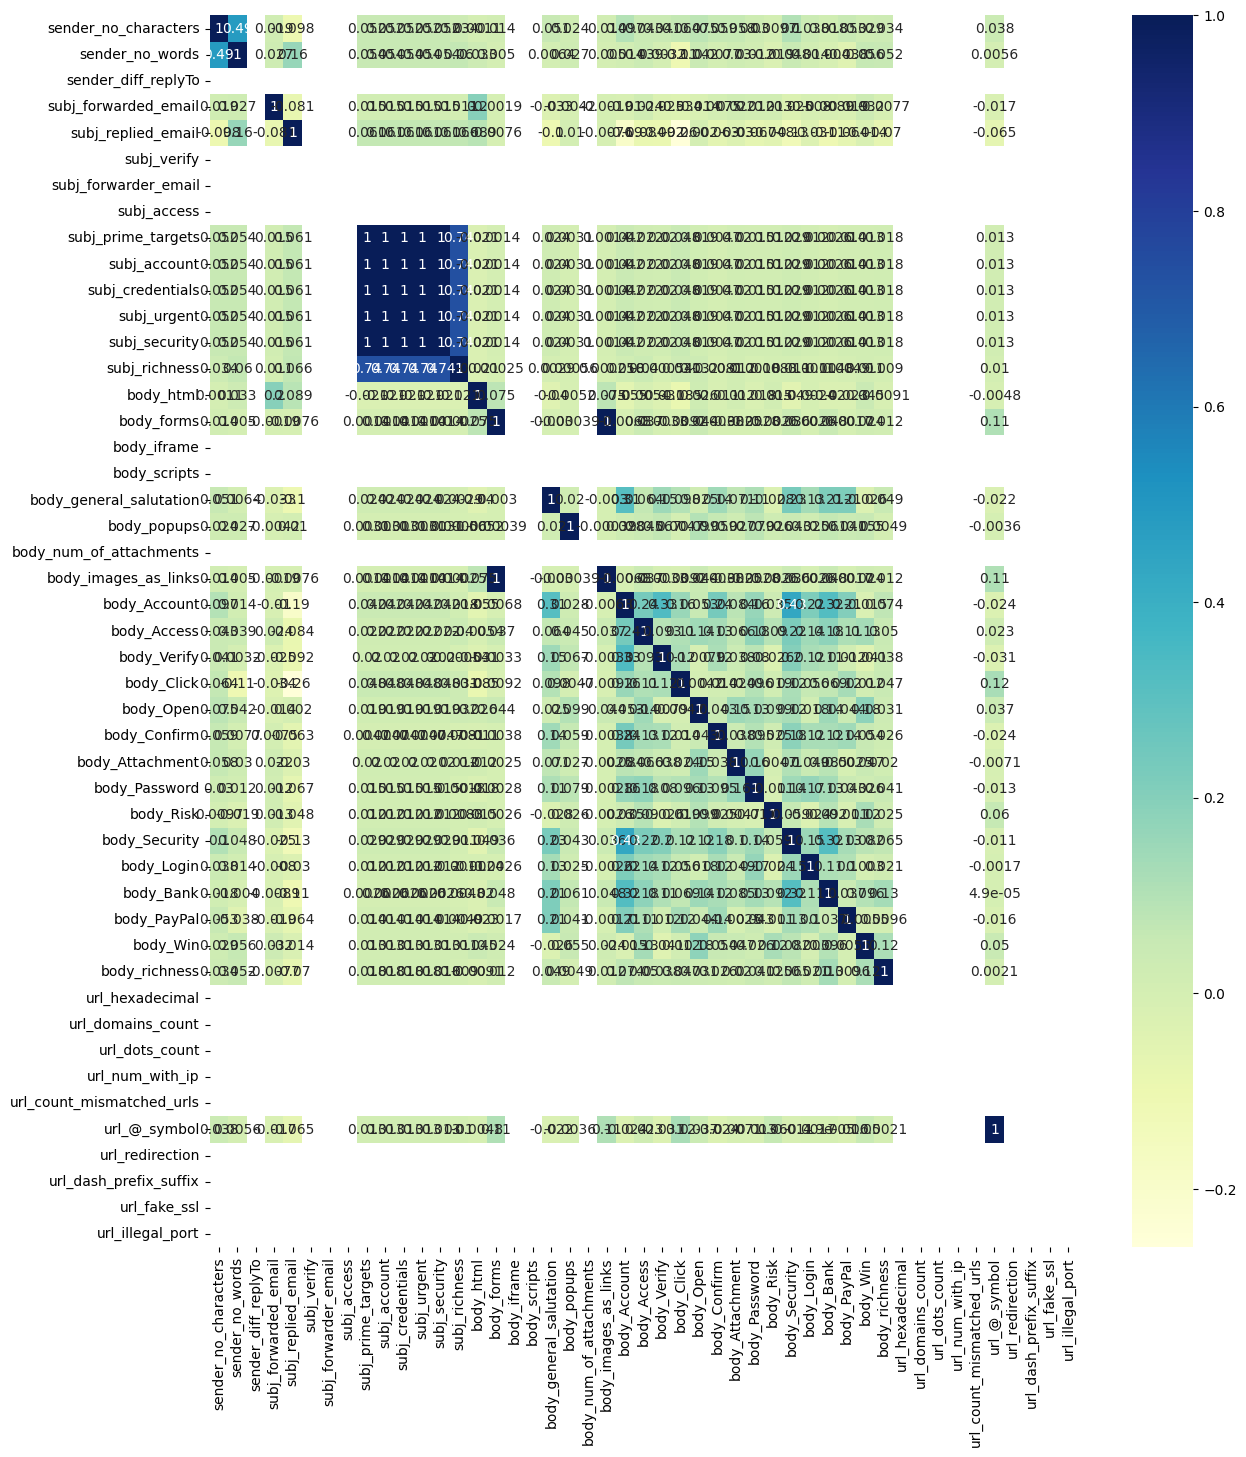

In [513]:
%matplotlib inline
plt.figure(figsize = (14,16))
sns.heatmap(features_df.corr(),annot=True,cmap="YlGnBu")

Sa heatmap-e sa slike mozemo vidjeti da ne postoji znacajna korelacija izmedju feature-a ali postoji odredjena korelacija izmedju:
-   Osjetljivih rijeci unutar subject kolone
-   Osjetljivih rijeci unutar body kolone
-   Popup-a  i Url-ova sa @ znakom sa rijeci 'Click'
-   General salutation-a i osjetljivih rijeci

### Redukcija dimenzionalnosti

PCA vizualizacija


In [514]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import seaborn as sn

scaled_data = StandardScaler().fit_transform(features_df.copy(deep=True))

pca = decomposition.PCA(n_components=2)

pca_model = pca.fit_transform(scaled_data)

# attaching the label for each 2-d data point
pca_data = np.vstack((pca_model.T, labels)).T

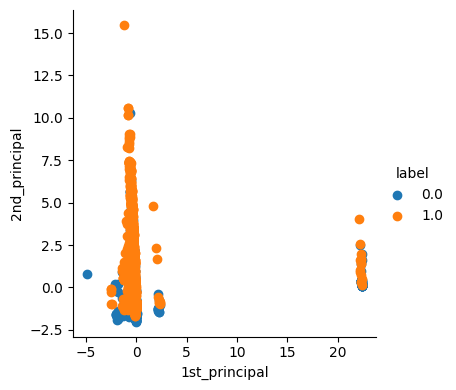

In [515]:
pca_df = pd.DataFrame(
    data=pca_data, columns=("1st_principal", "2nd_principal", "label")
)
sn.FacetGrid(pca_df, hue="label", height=4).map(
    plt.scatter, "1st_principal", "2nd_principal"
).add_legend()
plt.show()

Sa slike vidimo da je separacija medju klasama prilicno slaba, sto je i stvarno stanje, jer phishing mail-ovi teze da budu sto slicniji ham mail-ovima

PCA redukcija dimenzionalnosti

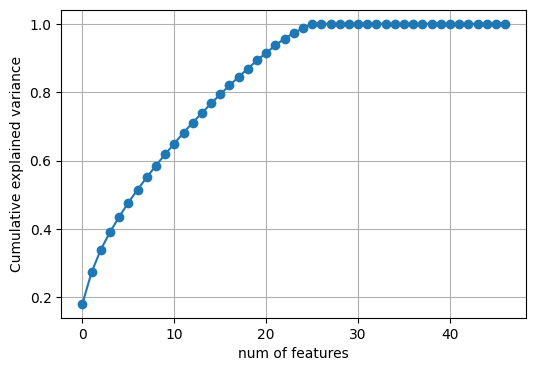

In [516]:
pca.n_components = len(features_df.columns)
pca_data = pca.fit_transform(scaled_data)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, marker="o")
plt.axis("tight")
plt.grid()
plt.xlabel("num of features")
plt.ylabel("Cumulative explained variance")
plt.show()

Sa grafa vidimo da ukoliko uzmemo 19 feature-a, ocuvacemo 90% varijanse

In [526]:
pca.n_components = len(features_df.columns)
pca_data = pca.fit_transform(scaled_data)

# Sort components by explained variance
sorted_indices = np.argsort(pca.explained_variance_ratio_)[::-1]

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.8) + 1

# Select the top 19 components or those that explain 90% variance
selected_components = sorted_indices[:n_components_90]

# Extract the original features corresponding to the selected components
selected_features_pca = features_df.columns[selected_components]

selected_features_pca

Index(['sender_no_characters', 'sender_no_words', 'sender_diff_replyTo',
       'subj_forwarded_email', 'subj_replied_email', 'subj_verify',
       'subj_forwarder_email', 'subj_access', 'subj_prime_targets',
       'subj_account', 'subj_credentials', 'subj_urgent', 'subj_security',
       'subj_richness', 'body_html', 'body_forms', 'body_iframe'],
      dtype='object')

Variance treshold

In [527]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0.05))
sel.fit(features_df)
cols = sel.get_support(indices=True)
features_df_new = features_df.iloc[:, cols]
selected_features_variance_filter = features_df_new.columns
selected_features_variance_filter

Index(['sender_no_characters', 'sender_no_words', 'subj_replied_email',
       'body_Account', 'body_Access', 'body_Verify', 'body_Click', 'body_Open',
       'body_Confirm', 'body_Security', 'body_Bank', 'body_Win',
       'body_richness'],
      dtype='object')

RandomForestRegressor

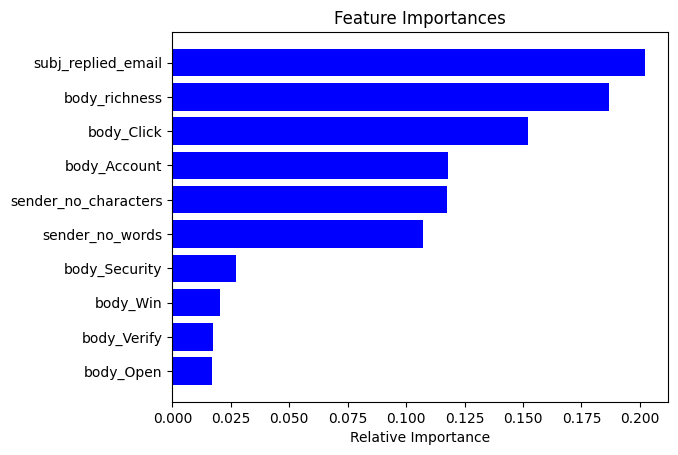

['subj_replied_email',
 'body_richness',
 'body_Click',
 'body_Account',
 'sender_no_characters',
 'sender_no_words',
 'body_Security',
 'body_Win',
 'body_Verify',
 'body_Open']

In [528]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

Filtered = features_df[selected_features_variance_filter]
X_trainn = Filtered
model = RandomForestClassifier(random_state=42, max_depth=10)
model.fit(X_trainn, labels)

features = X_trainn.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")

plt.show()

selected_features_random_forest_classifier = [features[index] for index in indices]
selected_features_random_forest_classifier.reverse()
selected_features_random_forest_classifier

Spajamo dobijene feature u skup

In [529]:
selected_features = []
selected_features.extend(selected_features_random_forest_classifier)
selected_features.extend(selected_features_variance_filter)
selected_features.extend(selected_features_pca)
selected_features = set(selected_features)
selected_features

{'body_Access',
 'body_Account',
 'body_Bank',
 'body_Click',
 'body_Confirm',
 'body_Open',
 'body_Security',
 'body_Verify',
 'body_Win',
 'body_forms',
 'body_html',
 'body_iframe',
 'body_richness',
 'sender_diff_replyTo',
 'sender_no_characters',
 'sender_no_words',
 'subj_access',
 'subj_account',
 'subj_credentials',
 'subj_forwarded_email',
 'subj_forwarder_email',
 'subj_prime_targets',
 'subj_replied_email',
 'subj_richness',
 'subj_security',
 'subj_urgent',
 'subj_verify'}

<Axes: >

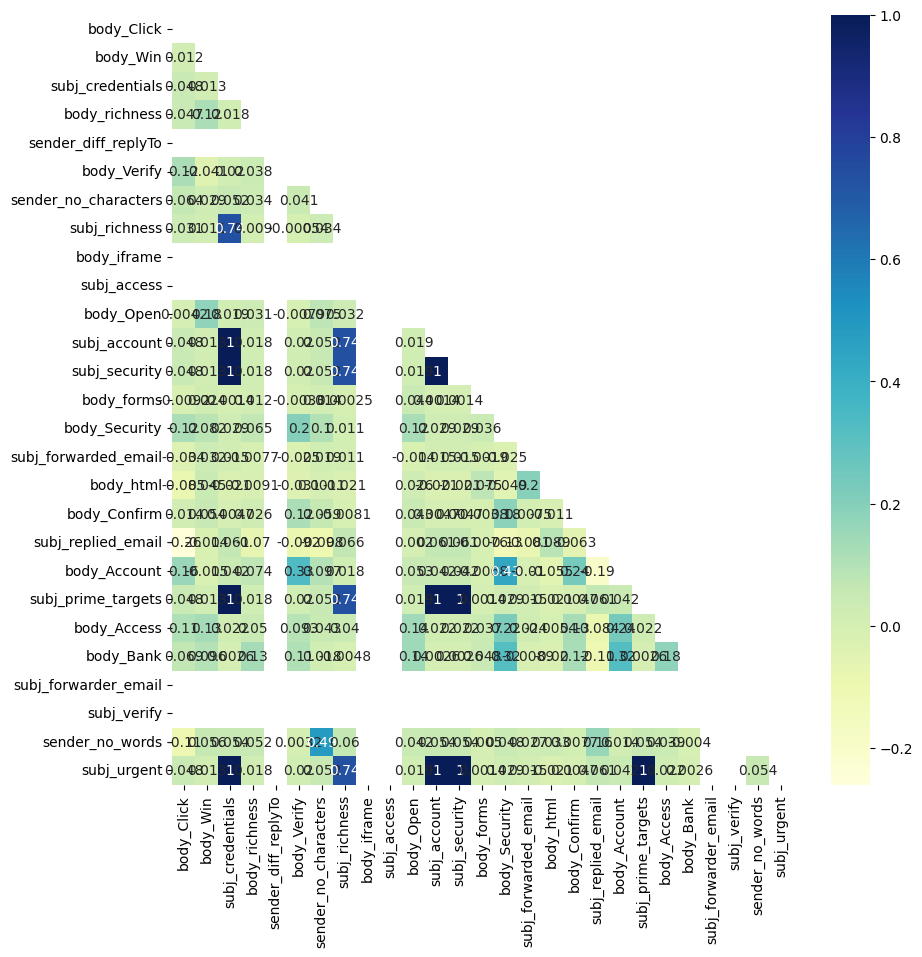

In [530]:
Filtered = features_df[list(selected_features)]
plt.figure(figsize=(10, 10))
# creating mask
mask = np.triu(np.ones_like(Filtered.corr()))


sns.heatmap(Filtered.corr(), annot=True, cmap="YlGnBu", mask=mask)

Dodajemo label kolonu

In [531]:
labeled_features_df = pd.concat([features_df[list(selected_features)], labels], axis=1)

### Cuvanje rezultata

In [533]:
labeled_features_df.to_csv("data/custom_features.csv", index=False)